In [1]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [6]:
train, val, test, data = (np.load("../data/task1_%s.npz" % f)
                    for f in ("train", "val", "test", "data"))
xtr, ytr, xval, yval, xte, yte, xdata, ydata = (
  torch.from_numpy(arr).float()
  for arr in (train["x"], train["y"], val["x"], val["y"], test["x"], test["y"], data["x"], data["y"])
)

# xtr has the format (num households, sequence length, input dim)

tensor([[[47.3801, 26.1112, 22.3342,  ..., 36.5000, 37.9722, 42.0003],
         [26.1112, 22.3342, 46.7851,  ..., 37.9722, 42.0003, 44.9050],
         [22.3342, 46.7851, 36.5000,  ..., 42.0003, 44.9050, 32.3923],
         ...,
         [26.9115, 37.2079, 32.3868,  ..., 40.2685, 31.2863, 38.4507],
         [37.2079, 32.3868, 35.3315,  ..., 31.2863, 38.4507, 32.1310],
         [32.3868, 35.3315, 40.2685,  ..., 38.4507, 32.1310, 34.1043]],

        [[34.7142, 23.2911, 24.5335,  ..., 17.9413, 24.2730, 27.0925],
         [23.2911, 24.5335, 19.1576,  ..., 24.2730, 27.0925, 20.2283],
         [24.5335, 19.1576, 17.9413,  ..., 27.0925, 20.2283, 15.9619],
         ...,
         [34.9349, 29.0823, 28.7628,  ..., 41.9301, 29.1214, 28.3322],
         [29.0823, 28.7628, 33.9839,  ..., 29.1214, 28.3322, 34.9949],
         [28.7628, 33.9839, 41.9301,  ..., 28.3322, 34.9949, 33.5494]],

        [[28.1954, 14.2777, 13.3912,  ...,  6.1021,  9.5328, 11.6327],
         [14.2777, 13.3912,  5.1413,  ...,  9

In [3]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 7

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [18]:
class RNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 7

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Propagate input through LSTM
        _, h_out = self.rnn(x, h_0)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [1]:
num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

#lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
rnn = RNN(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

x = xtr[0]
x = x[..., None]
y = ytr[0]
y = y[...,None]

# Train the model
for epoch in range(num_epochs):
    #outputs = lstm(x)
    outputs = rnn(x)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

NameError: name 'RNN' is not defined

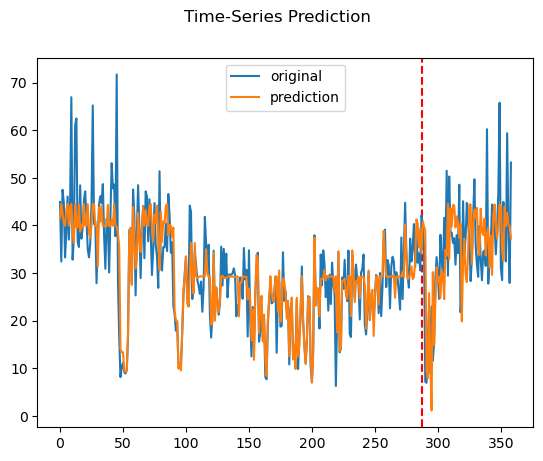

In [20]:
#lstm.eval()
rnn.eval()

xd= xdata[0][...,None]
#train_predict = lstm(xd)
train_predict = rnn(xd)

data_predict = train_predict.data.numpy()
dataY_plot = ydata[0].data.numpy()

training_length = int(len(xd)*0.8)
plt.axvline(x=training_length, c='r', linestyle='--')

plt.plot(dataY_plot, label="original")
plt.plot(data_predict, label="prediction")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()